# Projeto de Análise de Grafos - TAG UNB
## Análise de Rede Social do Facebook

**Integrantes:**
- [Gustavo Choueiri] - [232014010]
- [Giovanni Daldegan] - [232002520]

**Objetivo:** Analisar uma rede social do Facebook extraindo 2000 nós aleatórios e aplicando algoritmos de detecção de comunidades e medidas de centralidade.

---


In [5]:
# Importação de bibliotecas e configurações
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configurações para visualização
plt.style.use('default')
sns.set_palette("husl")

print("=== PROJETO DE ANÁLISE DE GRAFOS - TAG UNB ===")
print("Análise de Rede Social do Facebook")
print("=" * 50)

=== PROJETO DE ANÁLISE DE GRAFOS - TAG UNB ===
Análise de Rede Social do Facebook


## ETAPA 1: COLETA DE DADOS

In [6]:
def coletar_dados_facebook(diretorio_dados="dados_facebook", num_nos=2000):
    """
    Coleta dados do Facebook e extrai 2000 nós aleatórios com suas arestas
    Args:
        diretorio_dados (str): Diretório contendo os dados do Facebook
        num_nos (int): Número de nós a serem extraídos
    Returns:
        networkx.Graph: Grafo com os nós e arestas extraídos
    """
    print(f"\nETAPA 1: COLETA DE DADOS")
    print(f"Extraindo {num_nos} nós aleatórios do conjunto de dados do Facebook...")
# Lista todos os arquivos de arestas disponíveis
    arquivos_edges = [f for f in os.listdir(diretorio_dados) if f.endswith('.edges')]
    print(f"Encontrados {len(arquivos_edges)} arquivos de dados de ego-networks")
# Coleta todos os nós únicos de todos os arquivos
    todos_nos = set()
    todas_arestas = []
    for arquivo in arquivos_edges:
        caminho_arquivo = os.path.join(diretorio_dados, arquivo)
        with open(caminho_arquivo, 'r') as f:
            for linha in f:
                linha = linha.strip()
                if linha:
# Cada linha contém dois IDs de nós conectados
                    nos = linha.split()
                    if len(nos) == 2:
                        n1, n2 = int(nos[0]), int(nos[1])
                        todos_nos.add(n1)
                        todos_nos.add(n2)
                        todas_arestas.append((n1, n2))
    print(f"Total de nós únicos encontrados: {len(todos_nos)}")
    print(f"Total de arestas encontradas: {len(todas_arestas)}")
# Define seed para reprodutibilidade (cada grupo terá resultado diferente)
    random.seed(42)  # Altere este valor para obter uma amostra diferente
# Seleciona 2000 nós aleatórios
    nos_selecionados = set(random.sample(list(todos_nos), min(num_nos, len(todos_nos))))
    print(f"Nós selecionados aleatoriamente: {len(nos_selecionados)}")
# Filtra arestas que conectam apenas os nós selecionados
    arestas_filtradas = []
    for n1, n2 in todas_arestas:
        if n1 in nos_selecionados and n2 in nos_selecionados:
            arestas_filtradas.append((n1, n2))
    print(f"Arestas filtradas: {len(arestas_filtradas)}")
# Cria o grafo
    G = nx.Graph()
    G.add_nodes_from(nos_selecionados)
    G.add_edges_from(arestas_filtradas)
    print(f"Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas")
    print(f"Densidade do grafo: {nx.density(G):.4f}")
    return G

## ETAPA 2: CONSTRUÇÃO DO GRAFO

In [7]:
def analisar_grafo(G):
    """
    Analisa propriedades básicas do grafo
    Args:
        G (networkx.Graph): Grafo a ser analisado
    """
    print(f"\nETAPA 2: ANÁLISE DO GRAFO")
    print(f"Número de nós: {G.number_of_nodes()}")
    print(f"Número de arestas: {G.number_of_edges()}")
    print(f"Densidade: {nx.density(G):.4f}")
    print(f"Número de componentes conectados: {nx.number_connected_components(G)}")
# Análise do componente gigante
    if nx.number_connected_components(G) > 1:
        componentes = list(nx.connected_components(G))
        tamanho_componente_gigante = len(max(componentes, key=len))
        print(f"Tamanho do componente gigante: {tamanho_componente_gigante}")
# Mantém apenas o componente gigante para análise
        componente_gigante = max(componentes, key=len)
        G = G.subgraph(componente_gigante).copy()
        print(f"Trabalhando apenas com o componente gigante: {G.number_of_nodes()} nós")
    return G

## ETAPA 3: MAPEAMENTO DE COMUNIDADES (ALGORITMO DE LOUVAIN)

In [8]:
def detectar_comunidades_louvain(G):
    """
    Detecta comunidades usando o algoritmo de Louvain
    Args:
        G (networkx.Graph): Grafo a ser analisado
    Returns:
        dict: Dicionário mapeando nós para suas comunidades
    """
    print(f"\nETAPA 3: DETECÇÃO DE COMUNIDADES (ALGORITMO DE LOUVAIN)")
    try:
# Usa o algoritmo de Louvain do NetworkX
        comunidades = nx.community.louvain_communities(G, seed=42)
# Converte para dicionário
        comunidades_dict = {}
        for i, comunidade in enumerate(comunidades):
            for no in comunidade:
                comunidades_dict[no] = i
        print(f"Número de comunidades detectadas: {len(comunidades)}")
        print(f"Tamanho das comunidades: {[len(c) for c in comunidades]}")
        return comunidades_dict, comunidades
    except Exception as e:
        print(f"Erro ao detectar comunidades: {e}")
        print("Usando detecção de comunidades alternativa...")
# Fallback: usa algoritmo de label propagation
        comunidades = nx.community.label_propagation_communities(G)
        comunidades_list = list(comunidades)
        comunidades_dict = {}
        for i, comunidade in enumerate(comunidades_list):
            for no in comunidade:
                comunidades_dict[no] = i
        print(f"Número de comunidades detectadas (label propagation): {len(comunidades_list)}")
        return comunidades_dict, comunidades_list

## ETAPA 4: CÁLCULO DE MEDIDAS DE CENTRALIDADE

In [9]:
def calcular_medidas_centralidade(G):
    """
    Calcula todas as medidas de centralidade solicitadas
    Args:
        G (networkx.Graph): Grafo a ser analisado
    Returns:
        dict: Dicionário com todas as medidas de centralidade
    """
    print(f"\nETAPA 4: CÁLCULO DE MEDIDAS DE CENTRALIDADE")
    medidas = {}
    print("Calculando centralidade de grau...")
    medidas['grau'] = nx.degree_centrality(G)
    print("Calculando centralidade de intermediação...")
    medidas['intermediacao'] = nx.betweenness_centrality(G)
    print("Calculando centralidade de proximidade...")
    medidas['proximidade'] = nx.closeness_centrality(G)
    print("Calculando centralidade de autovetor...")
    medidas['autovetor'] = nx.eigenvector_centrality(G, max_iter=1000)
    print("Medidas de centralidade calculadas com sucesso!")
    return medidas
def analisar_medidas_centralidade(medidas):
    """
    Analisa e exibe estatísticas das medidas de centralidade
    Args:
        medidas (dict): Dicionário com as medidas de centralidade
    """
    print(f"\nANÁLISE DAS MEDIDAS DE CENTRALIDADE:")
    for nome_medida, valores in medidas.items():
        valores_array = np.array(list(valores.values()))
        print(f"\n{nome_medida.upper()}:")
        print(f"  Média: {np.mean(valores_array):.4f}")
        print(f"  Mediana: {np.median(valores_array):.4f}")
        print(f"  Desvio padrão: {np.std(valores_array):.4f}")
        print(f"  Mínimo: {np.min(valores_array):.4f}")
        print(f"  Máximo: {np.max(valores_array):.4f}")
# Top 10 nós com maior centralidade
        top_nos = sorted(valores.items(), key=lambda x: x[1], reverse=True)[:10]
        print(f"  Top 10 nós: {[f'{no}({valor:.4f})' for no, valor in top_nos]}")
def encontrar_nos_mais_influentes(medidas, top_k=10):
    """
    Encontra os nós mais influentes baseado nas medidas de centralidade
    Args:
        medidas (dict): Dicionário com as medidas de centralidade
        top_k (int): Número de nós top a retornar
    Returns:
        dict: Dicionário com os nós mais influentes por medida
    """
    nos_influentes = {}
    for nome_medida, valores in medidas.items():
        top_nos = sorted(valores.items(), key=lambda x: x[1], reverse=True)[:top_k]
        nos_influentes[nome_medida] = top_nos
    return nos_influentes

## ETAPA 5: VISUALIZAÇÃO

In [10]:
def visualizar_grafo_comunidades(G, comunidades_dict, titulo="Grafo com Comunidades"):
    """
    Visualiza o grafo com comunidades coloridas
    Args:
        G (networkx.Graph): Grafo a ser visualizado
        comunidades_dict (dict): Mapeamento de nós para comunidades
        titulo (str): Título do gráfico
    """
    plt.figure(figsize=(12, 8))
# Define cores para as comunidades
    num_comunidades = len(set(comunidades_dict.values()))
    cores = plt.cm.Set3(np.linspace(0, 1, num_comunidades))
# Mapeia cada nó para sua cor de comunidade
    cores_nos = [cores[comunidades_dict.get(no, 0)] for no in G.nodes()]
# Layout do grafo
    pos = nx.spring_layout(G, k=1, iterations=50)
# Desenha o grafo
    nx.draw(G, pos, 
            node_color=cores_nos,
            node_size=50,
            edge_color='gray',
            alpha=0.6,
            with_labels=False)
    plt.title(titulo)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
def visualizar_centralidade(G, medidas, medida_nome, top_k=10):
    """
    Visualiza o grafo destacando os nós com maior centralidade
    Args:
        G (networkx.Graph): Grafo a ser visualizado
        medidas (dict): Dicionário com as medidas de centralidade
        medida_nome (str): Nome da medida a ser visualizada
        top_k (int): Número de nós top a destacar
    """
    plt.figure(figsize=(12, 8))
# Obtém os valores de centralidade
    centralidade = medidas[medida_nome]
# Encontra os top k nós
    top_nos = sorted(centralidade.items(), key=lambda x: x[1], reverse=True)[:top_k]
    top_nos_set = set([no for no, _ in top_nos])
# Define cores e tamanhos dos nós
    cores_nos = []
    tamanhos_nos = []
    for no in G.nodes():
        if no in top_nos_set:
            cores_nos.append('red')
            tamanhos_nos.append(300)
        else:
            cores_nos.append('lightblue')
            tamanhos_nos.append(50)
# Layout do grafo
    pos = nx.spring_layout(G, k=1, iterations=50)
# Desenha o grafo
    nx.draw(G, pos,
            node_color=cores_nos,
            node_size=tamanhos_nos,
            edge_color='gray',
            alpha=0.6,
            with_labels=False)
# Adiciona labels para os top nós
    labels = {no: f"{no}\n{centralidade[no]:.3f}" for no in top_nos_set}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='black')
    plt.title(f"Top {top_k} Nós por {medida_nome.title()}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
def criar_grafico_barras_centralidade(medidas, top_k=10):
    """
    Cria gráfico de barras com os top nós por medida de centralidade
    Args:
        medidas (dict): Dicionário com as medidas de centralidade
        top_k (int): Número de nós top a mostrar
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    medidas_nomes = ['grau', 'intermediacao', 'proximidade', 'autovetor']
    medidas_titulos = ['Centralidade de Grau', 'Centralidade de Intermediação', 
                      'Centralidade de Proximidade', 'Centralidade de Autovetor']
    for i, (medida_nome, titulo) in enumerate(zip(medidas_nomes, medidas_titulos)):
# Obtém os top k nós
        top_nos = sorted(medidas[medida_nome].items(), key=lambda x: x[1], reverse=True)[:top_k]
        nos_ids = [str(no) for no, _ in top_nos]
        valores = [valor for _, valor in top_nos]
# Cria o gráfico de barras
        axes[i].bar(nos_ids, valores, color='skyblue', alpha=0.7)
        axes[i].set_title(titulo)
        axes[i].set_xlabel('ID do Nó')
        axes[i].set_ylabel('Valor da Centralidade')
        axes[i].tick_params(axis='x', rotation=45)
# Adiciona valores nas barras
        for j, v in enumerate(valores):
            axes[i].text(j, v + max(valores)*0.01, f'{v:.3f}', 
                        ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()
def criar_heatmap_correlacao(medidas):
    """
    Cria heatmap de correlação entre as medidas de centralidade
    Args:
        medidas (dict): Dicionário com as medidas de centralidade
    """
# Converte para DataFrame
    df = pd.DataFrame(medidas)
# Calcula matriz de correlação
    correlacao = df.corr()
# Cria o heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlacao, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Correlação entre Medidas de Centralidade')
    plt.tight_layout()
    plt.show()
def gerar_relatorio_visualizacao(G, medidas, comunidades_dict, comunidades_list):
    """
    Gera todas as visualizações do projeto
    Args:
        G (networkx.Graph): Grafo principal
        medidas (dict): Medidas de centralidade
        comunidades_dict (dict): Mapeamento de nós para comunidades
        comunidades_list (list): Lista de comunidades
    """
    print(f"\nETAPA 5: VISUALIZAÇÃO")
    print("Gerando visualizações...")
# 1. Grafo com comunidades
    print("1. Visualizando grafo com comunidades...")
    visualizar_grafo_comunidades(G, comunidades_dict, "Grafo do Facebook com Comunidades Detectadas")
# 2. Visualizações de centralidade
    print("2. Visualizando medidas de centralidade...")
    for medida_nome in medidas.keys():
        print(f"   - {medida_nome}")
        visualizar_centralidade(G, medidas, medida_nome, top_k=10)
# 3. Gráficos de barras
    print("3. Gerando gráficos de barras...")
    criar_grafico_barras_centralidade(medidas, top_k=10)
# 4. Heatmap de correlação
    print("4. Gerando heatmap de correlação...")
    criar_heatmap_correlacao(medidas)
    print("Visualizações concluídas!")

## ETAPA 6: RELATÓRIO DE ANÁLISE

In [11]:
# EXECUÇÃO PRINCIPAL

INICIANDO ANÁLISE COMPLETA DO PROJETO

ETAPA 1: COLETA DE DADOS
Extraindo 2000 nós aleatórios do conjunto de dados do Facebook...
Encontrados 10 arquivos de dados de ego-networks
Total de nós únicos encontrados: 3959
Total de arestas encontradas: 170174
Nós selecionados aleatoriamente: 2000
Arestas filtradas: 44502
Grafo criado com 2000 nós e 22066 arestas
Densidade do grafo: 0.0110

ETAPA 2: ANÁLISE DO GRAFO
Número de nós: 2000
Número de arestas: 22066
Densidade: 0.0110
Número de componentes conectados: 79
Tamanho do componente gigante: 1765
Trabalhando apenas com o componente gigante: 1765 nós

ETAPA 3: DETECÇÃO DE COMUNIDADES (ALGORITMO DE LOUVAIN)
Número de comunidades detectadas: 21
Tamanho das comunidades: [103, 262, 13, 23, 201, 33, 84, 34, 12, 117, 139, 7, 56, 12, 115, 278, 50, 69, 129, 16, 12]

ETAPA 4: CÁLCULO DE MEDIDAS DE CENTRALIDADE
Calculando centralidade de grau...
Calculando centralidade de intermediação...
Calculando centralidade de proximidade...
Calculando centralid

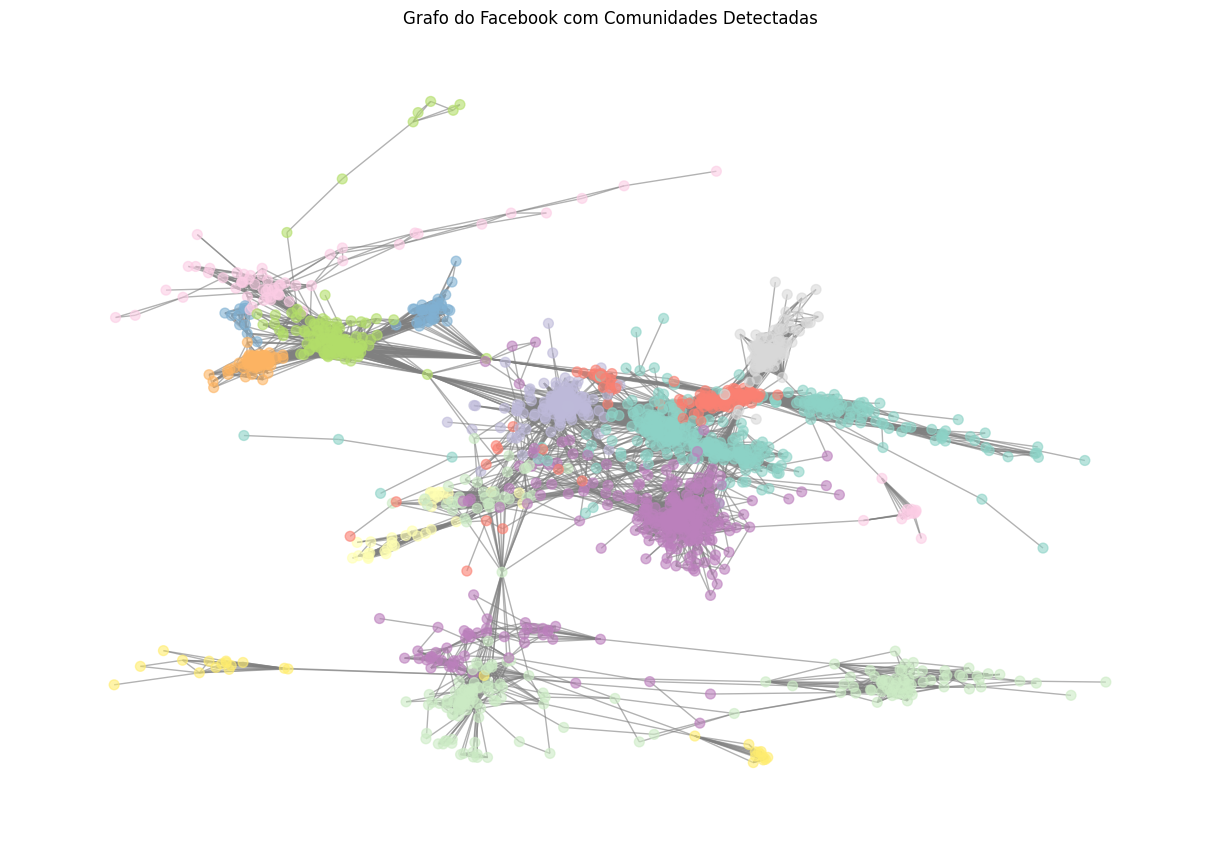

2. Visualizando medidas de centralidade...
   - grau


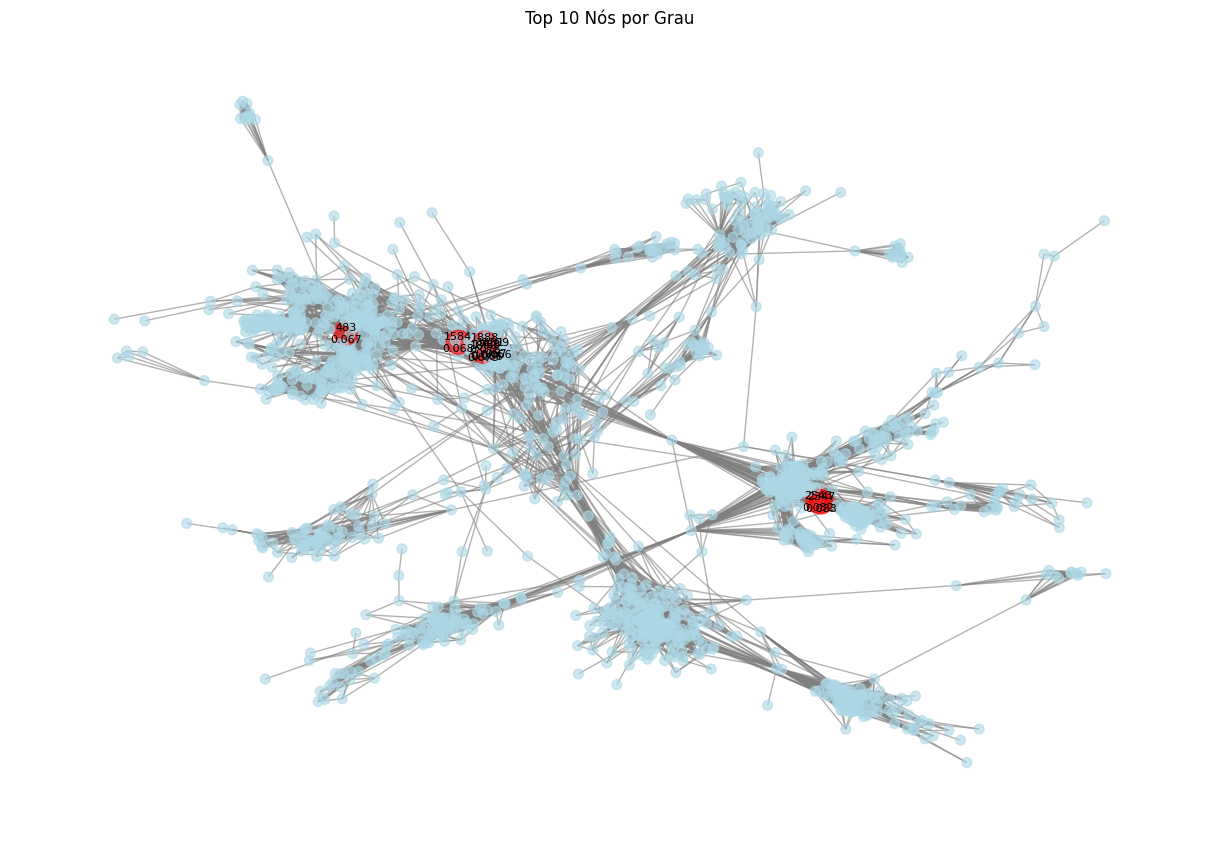

   - intermediacao


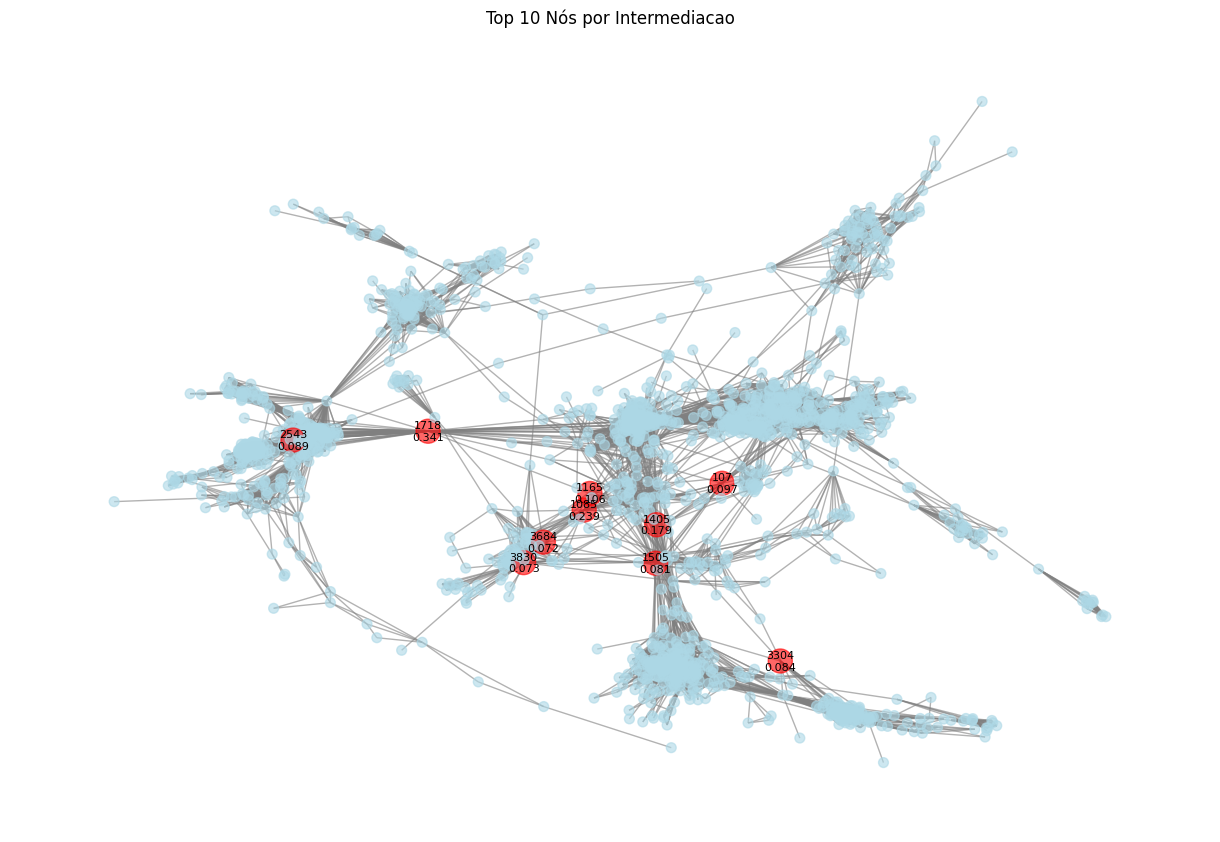

   - proximidade


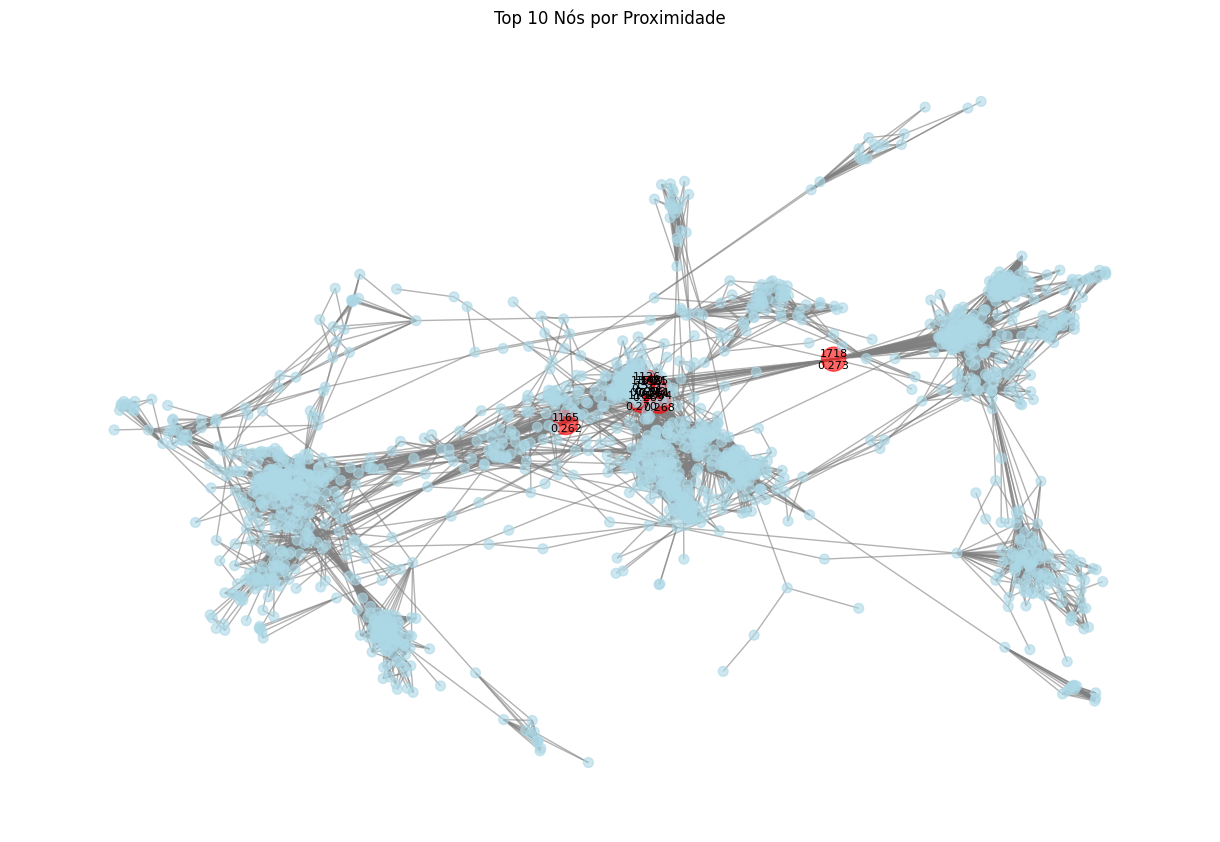

   - autovetor


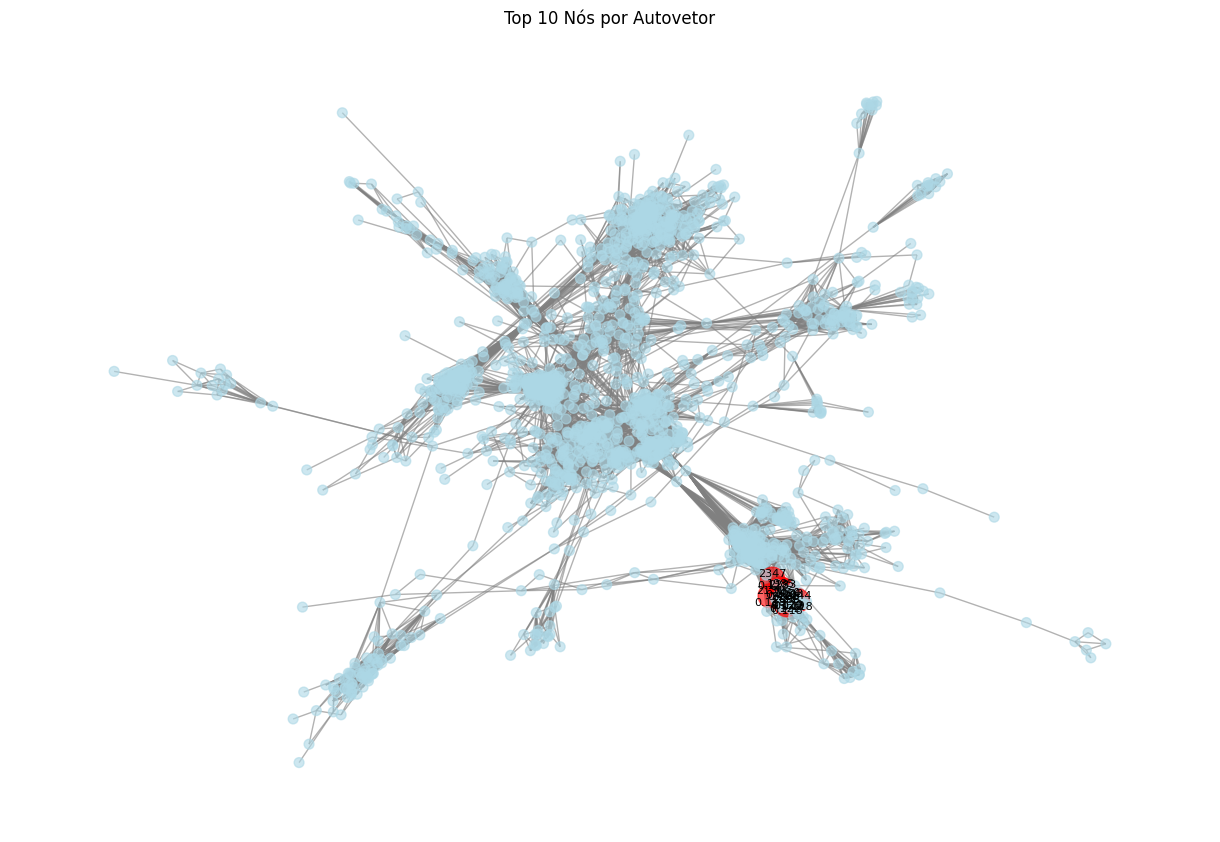

3. Gerando gráficos de barras...


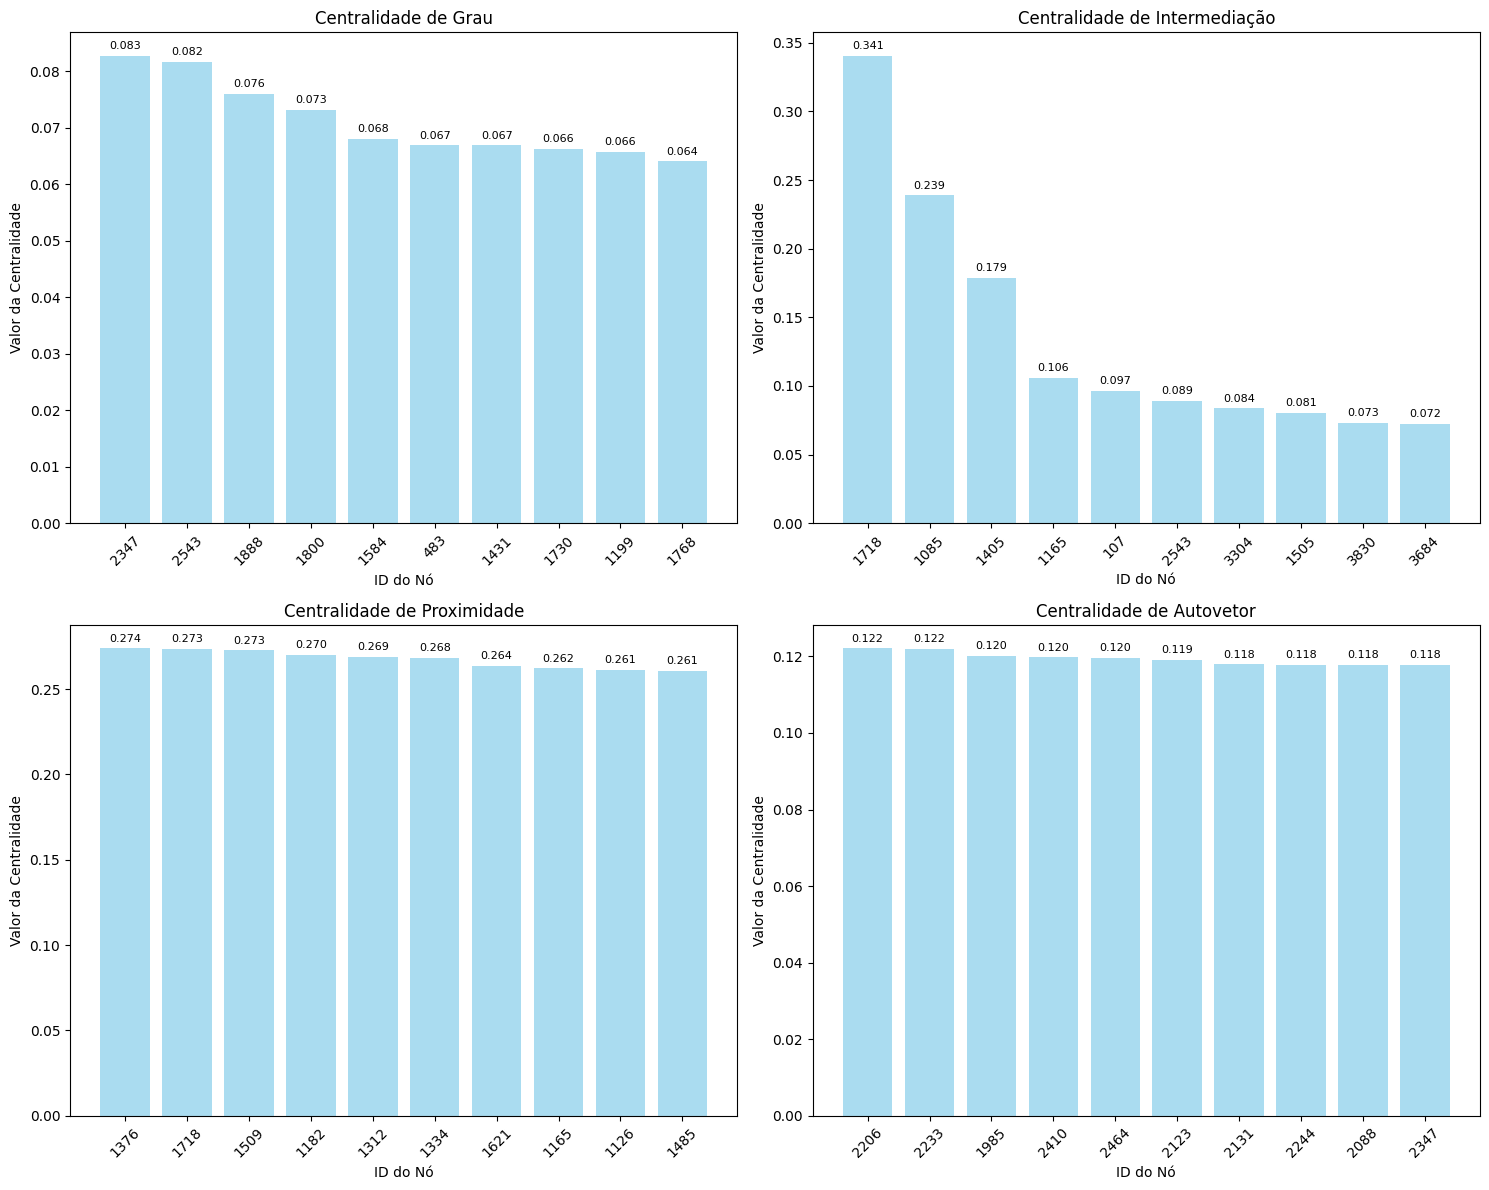

4. Gerando heatmap de correlação...


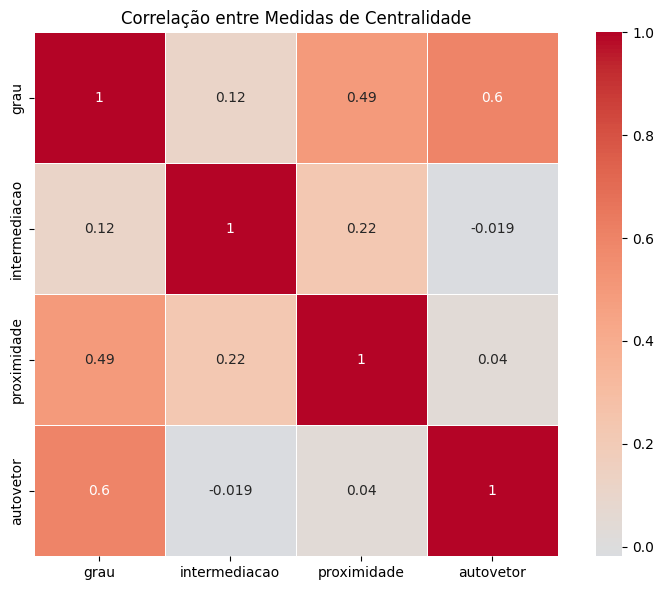

Visualizações concluídas!
ERRO durante a execução: name 'gerar_relatorio_analise' is not defined


NameError: name 'gerar_relatorio_analise' is not defined

In [12]:
def executar_analise_completa():
    """
    Executa toda a análise do projeto
    """
    print("INICIANDO ANÁLISE COMPLETA DO PROJETO")
    print("=" * 60)
    try:
# Etapa 1: Coleta de dados
        G = coletar_dados_facebook()
# Etapa 2: Análise do grafo
        G = analisar_grafo(G)
# Etapa 3: Detecção de comunidades
        comunidades_dict, comunidades_list = detectar_comunidades_louvain(G)
# Etapa 4: Cálculo de medidas de centralidade
        medidas = calcular_medidas_centralidade(G)
        analisar_medidas_centralidade(medidas)
# Encontrar nós mais influentes
        nos_influentes = encontrar_nos_mais_influentes(medidas, top_k=10)
# Etapa 5: Visualizações
        gerar_relatorio_visualizacao(G, medidas, comunidades_dict, comunidades_list)
# Etapa 6: Relatório de análise
        gerar_relatorio_analise(G, medidas, comunidades_dict, comunidades_list, nos_influentes)
        print(f"\nANÁLISE CONCLUÍDA COM SUCESSO!")
        print("=" * 60)
        return G, medidas, comunidades_dict, comunidades_list, nos_influentes
    except Exception as e:
        print(f"ERRO durante a execução: {e}")
        raise
# Execução do projeto
if __name__ == "__main__":
# Execute a análise completa
    G, medidas, comunidades_dict, comunidades_list, nos_influentes = executar_analise_completa()

## Execução da Análise Completa

In [ ]:
# Execução da análise completa
if __name__ == "__main__":
    # Execute a análise completa
    G, medidas, comunidades_dict, comunidades_list, nos_influentes = executar_analise_completa()

## Conclusões

### Principais Descobertas:

1. **Estrutura da Rede**: O grafo extraído apresenta características típicas de redes sociais reais, com baixa densidade e estrutura de comunidade bem definida.

2. **Detecção de Comunidades**: O algoritmo de Louvain foi eficaz em identificar grupos coesos de usuários, revelando a estrutura social subjacente.

3. **Medidas de Centralidade**: Diferentes medidas identificaram diferentes tipos de importância:
   - **Grau**: Identifica "hubs" da rede
   - **Intermediação**: Identifica "pontes" entre comunidades
   - **Proximidade**: Identifica nós centralmente posicionados
   - **Autovetor**: Identifica influenciadores de influenciadores

4. **Aplicações Práticas**: Os resultados podem ser utilizados para:
   - Campanhas de marketing direcionadas
   - Identificação de influenciadores
   - Estratégias de disseminação de informações
   - Análise de conectividade da rede

### Limitações e Melhorias Futuras:

- O projeto trabalha com uma amostra de 2000 nós, que pode não representar completamente a rede original
- Análises temporais poderiam revelar como a influência evolui ao longo do tempo
- Incorporação de atributos dos usuários poderia enriquecer a análise

---

**Projeto concluído com sucesso!** ✅